1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


Media 0.0872636096273171 ; Deviazione standard 0.9946089588763832


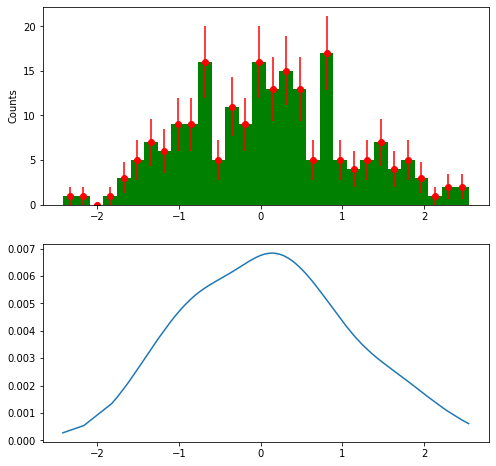

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats,integrate
%matplotlib inline

#N=int(input("Insert lenght of numpy"))
N=200
x=np.sort(np.random.randn(N))
print("Media",x.mean(),"; Deviazione standard",x.std())
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(2, 1, 1)
freq,bins,_=ax.hist(x,bins=30,color='g')
plt.ylabel("Counts") #stateful approach
plt.locator_params(axis="y", integer=True)#only integer ticks
bin_centers = 0.5*(bins[1:] + bins[:-1])#?????
plt.errorbar(bin_centers, freq, yerr=freq**0.5,color='r',fmt="o")

KDE=np.zeros(N)
for i in x:
    KDE=KDE+stats.norm.pdf(x,i,1.06*x.std()*x.size**(-1/5))
ag = fig.add_subplot(2, 1, 2)
normalization=integrate.trapz(KDE)
ag.plot(x,KDE/normalization,linestyle='-')

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

(2, 50)


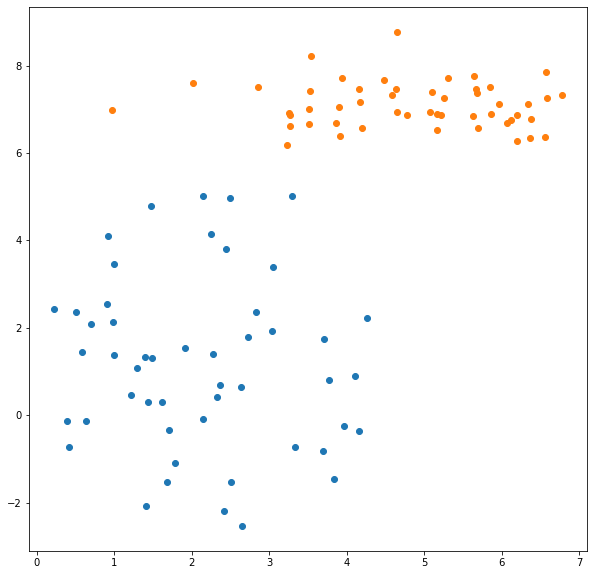

In [146]:
import random as rnd
def Gaussbuilder(xc,yc,stdx,stdy):
    #body, I can generate along x and y indipendently
    x=rnd.normalvariate(xc,stdx)
    y=rnd.normalvariate(yc,stdy)
    return x,y

#to extend to more plots, one must just add the new parameters in the lists
XCenters=[2,5]
YCenters=[1,7]
XSTD=[1,1.5]
YSTD=[2,0.5]
if not(len(XCenters)==len(YCenters)==len(XSTD)==len(YSTD)):
    print("Error: the number of parameters does not match")
Npoints=50
plt.figure(figsize=(10, 10))

Datax=np.empty(shape=(len(XCenters),Npoints))
Datay=np.empty(shape=(len(XCenters),Npoints))
print(Datax.shape)
for i in range(len(XCenters)):
    for j in range(Npoints):
        Datax[i,j],Datay[i,j]=Gaussbuilder(XCenters[i],YCenters[i],XSTD[i],YSTD[i])
    plt.plot(Datax[i,:],Datay[i,:],"o")


--2020-11-18 20:06:13--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Risoluzione di www.dropbox.com (www.dropbox.com)... 2620:100:6025:1::a27d:4501, 162.125.69.1
Connessione a www.dropbox.com (www.dropbox.com)|2620:100:6025:1::a27d:4501|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [segue]
--2020-11-18 20:06:14--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Riutilizzo della connessione esistente a [www.dropbox.com]:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://ucbc8f025d52d7e43d25bbac5c91.dl.dropboxusercontent.com/cd/0/inline/BDfDEAK3nfM5sbTNUkigFbMC_gB7zYhPgzHb3GpKxE_b1iQZCQKwEp6T_Lm68WztF5y8deffqe2973LuxiXq23oWf6MZQ5fHMeap3gd-kAj4rw/file# [segue]
--2020-11-18 20:06:15--  https://ucbc8f025d52d7e43d25bbac5c91.dl.dropboxusercontent.com/cd/0/inline/BDfDEAK3nfM5sbTNUkigFbMC_gB7zYhPg

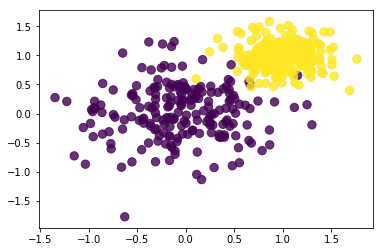

In [109]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [2]:
! wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

--2020-11-20 10:37:31--  https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/hgnvyj9abatk8g6/residuals_261.npy [segue]
--2020-11-20 10:37:31--  https://www.dropbox.com/s/raw/hgnvyj9abatk8g6/residuals_261.npy
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://uc0e598ef484bef65917aada06d3.dl.dropboxusercontent.com/cd/0/inline/BDgF_lk0ITYyk0U4T4q8KwQ8UGDo9WLfufvdm-azo9s6aglmzCBOCIR5od6jPWYI8k8hp5dGsJdCx1TwFOUfRZ72yGzVBSKd4DYgqjY6PxkQmQ/file# [segue]
--2020-11-20 10:37:32--  https://uc0e598ef484bef65917aada06d3.dl.dropboxusercontent.com/cd/0/inline/BDgF_lk0ITYyk0U4T4q8KwQ8UGDo9WLfufvdm-azo9s6aglmzCBOCIR5od6jPWYI8k8hp5dGsJdCx1TwFOUfRZ72yGz

<ErrorbarContainer object of 3 artists>

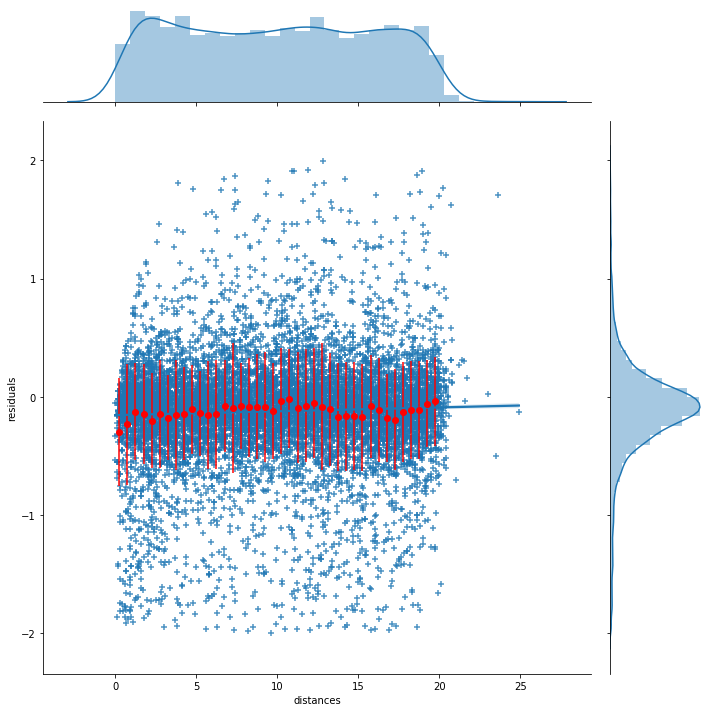

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


Data=np.load("residuals_261.npy",allow_pickle=True).item()
df = pd.DataFrame(Data)
Cleaned=df[abs(df["residuals"])<2]
stats.linregress(Cleaned["distances"],Cleaned["residuals"])
sns.jointplot(x="distances", y="residuals", data=Cleaned,marker='+',height=10,kind="reg")

bindensity=2        #Nbins per unit
bins=np.array([i/bindensity for i in range(0,20*bindensity+1)])
     #+1 because we want the last number in range included
bin_centers = 0.5*(bins[1:] + bins[:-1])

Y=np.empty(shape=len(bin_centers))
ErrY=np.empty(shape=len(bin_centers))
b_halfwidth=1/bindensity/2   #Half width of a bin

for j,i in enumerate(bin_centers):
    temp=Cleaned[abs(Cleaned["distances"]-i)<b_halfwidth]
    Y[j]=temp["residuals"].mean()
    ErrY[j]=temp["residuals"].std()
plt.errorbar(bin_centers, Y, yerr=ErrY,color='r',fmt="o")